# Test: Based on the confidence, which results should be discarded?

In [1]:
# Import packages
import random
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
from sklearn.datasets import make_classification

from Bias import BIASme, bias_rotate_2D
from Transformations import remove_outliers_lof, trafo_keep_axes
from DensityEstimators import DE_kde
from IMITATE import IMITATE

In [26]:
def generateData_pill(dummy, dataset_size):
    data, labels = make_classification(
        n_samples=10000,
        n_features=2,
        n_informative=2,
        n_redundant=0,
        n_classes=1,
        n_clusters_per_class=1,
        flip_y=0,  # noise
        random_state=2210)
    data = np.array(data[0:dataset_size, (0, 1)])        # cut away dummy dimension
    labels = np.array([0] * dataset_size)
    return data, labels

In [19]:
def conf_experiment(t, dataset_size=10000):
    bias_gen = lambda a, b: bias_rotate_2D(training=a, labels=b, alpha=0.5*np.pi, biasedClass=0)
    data_gen = lambda a: generateData_pill(a, dataset_size)
    DE = lambda b: DE_kde(num_bins=b, kernel='gau')
    bh = IMITATE([15], bias_gen, data_gen, repeat=1, DE=DE, trafo=trafo_keep_axes)
    bh.fill_up(30, iterations=1, fill_up_plots=False, point_plots=True, RO=True, t=t)

# Comparison with sample of training set
To decide if the result should be discarded or not, each point's average distance $d_p$ to the $10$ nearest neighbors is compared to the average distance $d$ to the $10$ nearest neighbors in a random subset of the training set that has the same size as the set of added points. If $d_p <= d + t\cdot \text{std}$, the point remains, otherwise it is discarded.

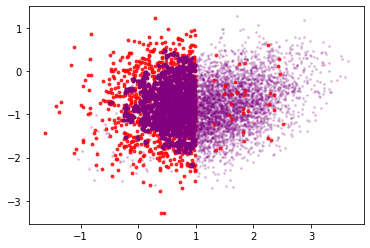

In [9]:
conf_experiment(t=0)

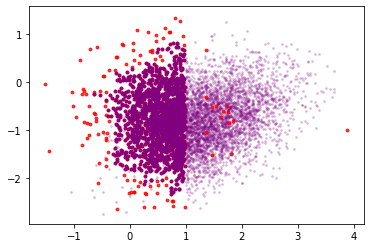

In [12]:
conf_experiment(t=1)

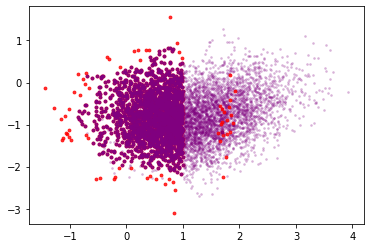

In [14]:
conf_experiment(t=2)

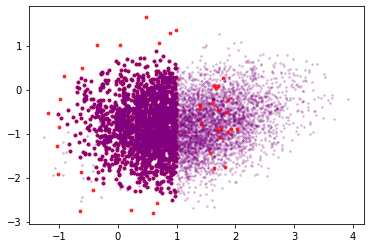

In [15]:
conf_experiment(t=3)

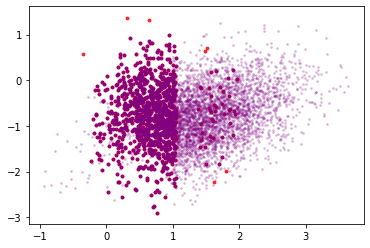

In [16]:
conf_experiment(t=4)

As can be seen above, $t=0$ clearly removes too many points, $t=4$ does not remove the noise for $x>1$, so both values are not an option and the desired value for $t$ must be in the interval $(0,4)$. $t=3$ still removes the noise for $x>1$, but leaves rather sparse areas surrounding the center of the reconstructed points behind. We only want to identify the zones in which IMITATE is very sure, so we decide to choose $t=1$ s it leaves a dense area behind without cutting away too much.

# What happens for different training set sizes?
We want to make sure that the training set size does not influence the best parameter choice.

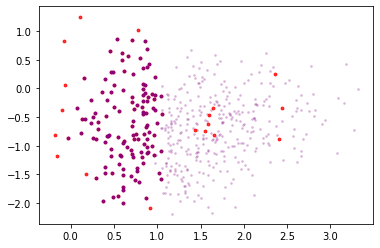

In [29]:
conf_experiment(t=1, dataset_size=1000)

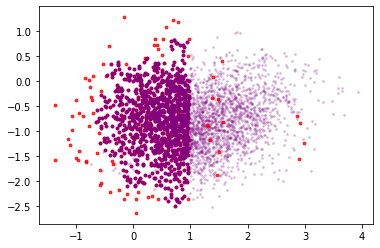

In [34]:
conf_experiment(t=1, dataset_size=5000)

For different dataset sizes, the choice $t=1$ still does what we want. It removes noise and outliers and leaves points behind that form a similarly dense cluster as the input data.

# Appendix: Why not a different comparison?
Instead of comparing to a subset of the training data, we tried different other comparisons that all came with certain drawbacks. If we don't make any assumptions on the dataset, we can not give a solution that always works. And if we make certain assumptions, we can't assume that it works in all cases. The comparison with a subset seemed to be the most stable option in our experiments, but it might not work in all cases, i.e., it becomes unstable for very small sets. We overcome this drawback by repeating the experiment several times and choosing the result with the highest density of the added points. 

Other comparison techniques could be the following:
- *Compare with random points*: Our goal is to distinguish the cases of more or less random noise spread all over the cube from the case where the algorithm outputs points focused in a certain area, so why not compare to the density of random points? The answer is simple: For random points, we need to give a bounding box in which we generate random points. That box would be determined by the box in which the training set lies, so the density is heavily influenced by the size of the box. Since the box size is not related to the quality of the output, we want to avoid that connection.
- *Compare with fixed size sets*: Assume we use the average 10NN-distance of the entire training set. That gives advantage to large sets of added points, even if they are sparse. 

# Why 10 nearest neighbors?
After all, 10 is a heuristic. We want to avoid making too many assumptions on the dataset, so we don't use it to estimate the optimal number $k$ of nearest neighbors. The number of neighbors needs to be restricted because otherwise,e.g., in banana-shaped datasets, points further away from the center are disadvantaged, even if they are in a dense area, so they will be removed. If we choose $k$ too small, the average distance to the neighbors becomes unreliable. 

$k$ could be oriented on the number of bins that are used for the density estimation, but since confidence is used to determine the best bin number, that is not an option (it would render the confidence comparison invalid).